# Problem Session: Model Evaluation

In [1]:
import pandas as pd
import numpy as np

Import `simulated_subject_data.csv` as `df`.

In [2]:
df = pd.read_csv('simulated_subject_data.csv')
df.head()

,x1,x2,x3,subject_id,target
0,-0.598447,1.155336,0.704862,92,13.952998
1,-0.830818,-0.019040,0.094150,51,9.773621
2,2.260795,0.523222,-1.545058,14,13.664964
3,0.306551,-0.754097,-0.874351,87,10.162137
4,-0.885801,-0.817873,-1.524239,19,7.383404


What are the unique values of the `subject_id` field?

In [3]:
np.sort(df["subject_id"].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
np.array_equal(np.sort(df["subject_id"].unique()), np.arange(100))

True

These data will be used in a predictive regression model.  We should approach model validation differently depending on our goals:

1. Case 1:  We do not need to generalize to new `subject_id`s in the future, so we can treat `subject_id` as a categorical feature.  For instance, if each `subject_id` corresponds to a vendor we do business with, and we engage with a new vendor only very rarely, then it would be appropriate to predict a new row given knowledge of our previous history with the vendor. In this case a regular `train_test_split` and `KFold` would be appropriate.
2. Case 2:  We do need to generalize to new `subject_id`'s in the future.  We cannot treat `subject_id` as a feature in this case.  For instance, if `subject_id` corresponds to a subject in a medical trial, and each row corresponds to a biophysical measurement under different conditions, then we want to be able to predict what a *new* subject will do under novel conditions.  We should assess our models using data splits which randomly assign different subjects to the training or holdout sets.

For this problem set we will do *both* and see the difference in model performance.  This will illustrate the danger of using option 1 when you should really be using option 2.

In [ ]:
# Make a train/test split for case 1.  Use random state 216, and test size 0.2
# Use the names X_train_1, X_test_1, y_train_1, y_test_1
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df[['x1', 'x2', 'x3', 'subject_id']], df['target'], random_state=216, test_size=0.2)

In [ ]:
# Make a train/test split for case 2. Put random 20 of the subject_ids in test, the rest in train.
# Use the names X_train_2, X_test_2, y_train_2, y_test_2
# There is no built-in such splitter, so you will need to write this code by hand.

# Shuffle subject IDs
unique_ids = np.unique(df["subject_id"])
rng = np.random.default_rng(42)
rng.shuffle(unique_ids)

# 80/20 split of subject IDs
cut = int(0.8 * len(unique_ids))
train_ids = unique_ids[:cut]
test_ids = unique_ids[cut:]

# Boolean masks
train_mask = df["subject_id"].isin(train_ids)
test_mask = ~train_mask

X_train_2, y_train_2 = df.loc[train_mask, ["x1", "x2", "x3", "subject_id"]], df.loc[train_mask, "target"]
X_test_2, y_test_2 = df.loc[test_mask, ["x1", "x2", "x3", "subject_id"]], df.loc[test_mask, "target"]


Let's do some EDA using `X_train_2` and `y_train_2`.  Make some graphs of the target against each feature.  What do you notice?

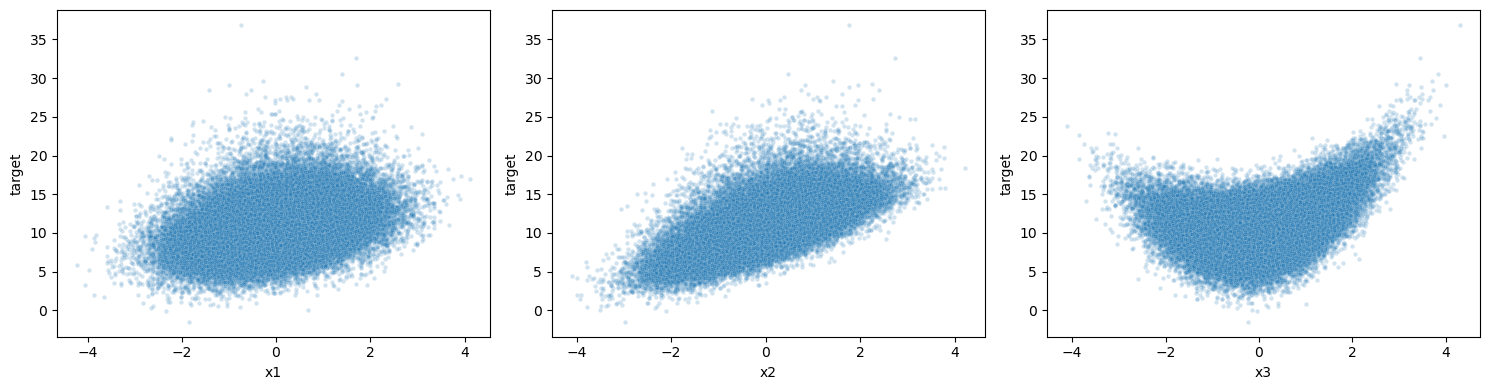

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(["x1", "x2", "x3"]):
    sns.scatterplot(x=X_train_2[col], y=y_train_2, alpha=0.2, s=10, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("target")


plt.tight_layout()
plt.show()

Possible linear dependence on `x1` and `x2`, and maybe a quadratic dependence on `x3`?

Let's first get a little practice with residual plots.  Fit a linear regression model to `(X_train_2, y_train_2)` using only the features $x_1, x_2, x_3$. Graph the residuals against each feature and also against the predicted values.  What do you see?


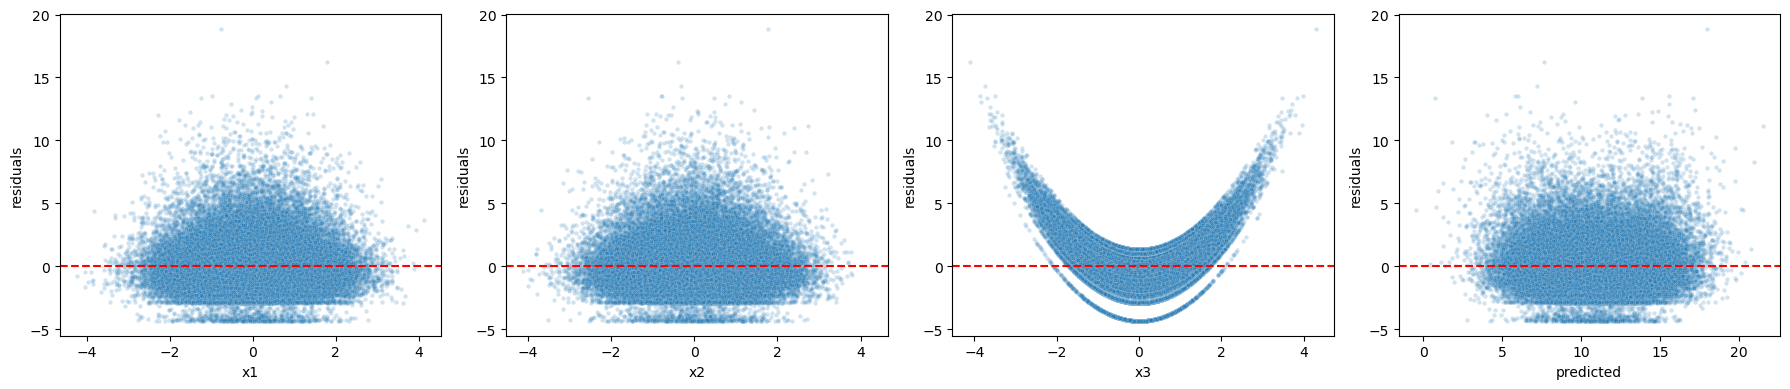

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Fit linear model on training data
lin = LinearRegression()
lin.fit(X_train_2[['x1','x2', 'x3']], y_train_2)
y_pred = lin.predict(X_train_2[['x1','x2', 'x3']])
resid = y_train_2 - y_pred

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Residuals vs x1, x2, x3
for i, col in enumerate(["x1", "x2", "x3"]):
    sns.scatterplot(x=X_train_2[col], y=resid, alpha=0.2, s=10, ax=axes[i])
    axes[i].axhline(0, color="red", linestyle="--")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("residuals")

# Residuals vs predicted
sns.scatterplot(x=y_pred, y=resid, alpha=0.2, s=10, ax=axes[3])
axes[3].axhline(0, color="red", linestyle="--")
axes[3].set_xlabel("predicted")
axes[3].set_ylabel("residuals")

plt.tight_layout()
plt.show()


We very clearly see that we have "un-modeled signal" in the form of a quadratic dependence on $x_3$.

We will now compare 4 different models, using the splitting strategy from Case 2:

1. A baseline model which predicts the mean of the training targets.
2. The linear regression model with features $x_1, x_2, x_3$.
3. The linear regression model with features $x_1, x_2, x_3, x_3^2$.
4. A random forest regression model with features $x_1, x_2, x_3$.

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error as rmse

models = {
    "dummy_mean": DummyRegressor(strategy="mean"),
    "linear": LinearRegression(),
    "linear_x3_sq": Pipeline([
        ("add_x3_sq", ColumnTransformer([
            ("pass", "passthrough", ["x1", "x2", "x3"]),
            ("x3_sq", FunctionTransformer(lambda z: z ** 2), ["x3"]),
        ], remainder="drop")),
        ("linreg", LinearRegression())
    ]),
    "random_forest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
}

gkf = GroupKFold(n_splits=5)

rows = []
for name, model in models.items():
    oof_pred = cross_val_predict(
        estimator=model,
        X=X_train_2,
        y=y_train_2,
        cv=gkf.split(X_train_2[['x1', 'x2', 'x3']], y_train_2, groups=X_train_2['subject_id']),
        n_jobs=-1
    )
    oof_rmse = rmse(y_train_2, oof_pred)

    model.fit(X_train_2[['x1', 'x2', 'x3']], y_train_2)
    in_pred = model.predict(X_train_2[['x1', 'x2', 'x3']])
    in_rmse = rmse(y_train_2, in_pred)

    rows.append((name, in_rmse, oof_rmse))

summary = pd.DataFrame(rows, columns=["model", "in_sample_rmse", "out_of_sample_rmse"]) \
           .sort_values("out_of_sample_rmse") \
           .reset_index(drop=True)


In [10]:
summary

,model,in_sample_rmse,out_of_sample_rmse
0,linear_x3_sq,1.053791,1.070129
1,random_forest,0.414471,1.195804
2,linear,1.765070,1.775337
3,dummy_mean,3.033068,3.038510


Finally, let's see what kind of performance we would get using the quadratic model if we use `train_test_split`, `KFold`, and one-hot encode `subject_id`.

In [11]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Column transformer: x1,x2,x3 as-is, add x3^2, one-hot encode subject_id
ct = ColumnTransformer([
    ("numeric", "passthrough", ["x1","x2","x3"]),
    ("x3_sq", FunctionTransformer(lambda z: z**2), ["x3"]),
    ("id", OneHotEncoder(handle_unknown="ignore"), ["subject_id"])
])

pipe = Pipeline([
    ("features", ct),
    ("linreg", LinearRegression())
])

# In-sample RMSE
pipe.fit(X_train_1, y_train_1)
y_pred_in = pipe.predict(X_train_1)
in_rmse = root_mean_squared_error(y_train_1, y_pred_in)

# Out-of-sample RMSE (row-wise KFold, no grouping)
kf = KFold(n_splits=5, shuffle=True, random_state=216)
y_pred_oof = cross_val_predict(pipe, X_train_1, y_train_1, cv=kf, n_jobs=-1)
out_rmse = root_mean_squared_error(y_train_1, y_pred_oof)

print("In-sample RMSE:", in_rmse)
print("Out-of-sample RMSE (row-wise KFold):", out_rmse)


In-sample RMSE: 9.192671911432805e-06
Out-of-sample RMSE (row-wise KFold): 9.688059527264983e-06


We can see that if we were actually in Case 2, but mistakenly followed the validation strategy from Case 1, we could convince ourselves that the model performs **way better** than it actually will when applied to new subjects.